In [3]:
%load_ext dotenv
%dotenv

import flax
from flax import nnx
from flax import linen as nn
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import einops
import clu
from clu import parameter_overview

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


# Initialization

In [4]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1717476906.357859  247371 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717476906.382384  247371 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717476906.382511  247371 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1717476906.383645  247371 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

In [5]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()


global RANDOM_KEY
RANDOM_KEY = jax.random.PRNGKey(4)

def get_random_key():
    global RANDOM_KEY
    RANDOM_KEY, subkey = jax.random.split(RANDOM_KEY)
    return subkey

def set_random_key(seed):
    global RANDOM_KEY
    RANDOM_KEY = jax.random.PRNGKey(seed)

def reset_random_key():
    global RANDOM_KEY
    RANDOM_KEY = jax.random.PRNGKey(4)

# Data Pipeline

In [6]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            return image

        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()  # Cache after augmenting to avoid recomputation
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)

# Noise Schedules

In [7]:
class DiffusionSchedule:
    def __init__(self, max_timesteps, 
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = max_timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

    def generate_timesteps(self, batch_size):
        return jax.random.uniform(get_random_key(), (batch_size, 1), minval=0, maxval=self.max_timesteps, dtype=jnp.int32)
    
    def clip_images(self, images):
        return jnp.clip(images, self.clip_min, self.clip_max)

    # Return the signal and noise rates for each timestep
    def get_rates(self, steps):
        raise NotImplementedError

    # Used while training
    def add_noise(self, images, noise, steps, rates=None):
        if rates is None:
            signal_rates, noise_rates = self.get_rates(steps)
        else:
            signal_rates, noise_rates = rates
        return signal_rates * images + noise_rates * noise

    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        # Scale 't' to the range [0, 1]
        if rates is None:
            signal_rates, noise_rates = self.get_rates(steps)
        else:
            signal_rates, noise_rates = rates
        pred_images = (noisy_images - noise_rates * noise) / signal_rates
        if clip_denoised:
            pred_images = jnp.clip(pred_images, -1, 1)
        return pred_images
    
    # Used to sample from the diffusion model
    def sample_step(self, noisy_images, noise, steps, step_size=1, clip_denoised=True, last_step=False):
        signal_rates, noise_rates = self.get_rates(steps)
        # First clip the noisy images
        pred_images = self.remove_all_noise(noisy_images, noise, steps, clip_denoised, rates=(signal_rates, noise_rates))
        # Now add some noise back to the clean images
        if last_step:
            return pred_images
        
        return self._renoise(pred_images, noisy_images, steps, step_size=step_size)
    
    def _renoise(self, pred_images, noisy_images, steps, step_size=1):
        return NotImplementedError
    
    # Used while training
    def transform_steps(self, steps):
        return steps

class DDPMLinearSchedule(DiffusionSchedule):
    def __init__(self, timesteps=1000, 
                 beta_start = 1e-4,
                    beta_end = 0.02,
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        self.beta_start = beta_start
        self.beta_end = beta_end

        # The linear variance schedule
        self.betas = jnp.linspace(beta_start, beta_end, timesteps, dtype=jnp.float32)
        alphas = 1 - self.betas
        self.alpha_cumprod = jnp.cumprod(alphas, axis=0)
        self.alpha_cumprod_prev = jnp.append(1.0, self.alpha_cumprod[:-1])

        # self.alpha_cumprod = jnp.reshape(self.alpha_cumprod, (-1, 1, 1, 1))
        # self.alpha_cumprod_prev = jnp.reshape(self.alpha_cumprod_prev, (-1, 1, 1, 1))

        self.sqrt_alpha_cumprod = jnp.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = jnp.sqrt(1 - self.alpha_cumprod)

        self.posterior_variance = self.betas * (1 - self.alpha_cumprod_prev) / (1 - self.alpha_cumprod)
        self.posterior_mean_coef1 = self.betas * jnp.sqrt(self.alpha_cumprod_prev) / (1 - self.alpha_cumprod)

        self.posterior_mean_coef2 = (1 - self.alpha_cumprod_prev) * jnp.sqrt(alphas) / (1 - self.alpha_cumprod)
        self.posterior_log_variance_clipped = jnp.log(jnp.maximum(self.posterior_variance, 1e-20))

    def get_rates(self, steps):
        signal_rate = self.sqrt_alpha_cumprod[steps]
        noise_rate = self.sqrt_one_minus_alpha_cumprod[steps]
        signal_rate = jnp.reshape(signal_rate, (-1, 1, 1, 1))
        noise_rate = jnp.reshape(noise_rate, (-1, 1, 1, 1))
        return signal_rate, noise_rate
    
    def _renoise(self, pred_images, noisy_images, steps, step_size=1):
        # First estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        signal_mean = self.posterior_mean_coef1[steps]
        noise_mean = self.posterior_mean_coef2[steps]
        signal_mean = jnp.reshape(signal_mean, (-1, 1, 1, 1))
        noise_mean = jnp.reshape(noise_mean, (-1, 1, 1, 1))
        mean = signal_mean * pred_images + noise_mean * noisy_images
        log_variance_clipped = self.posterior_log_variance_clipped[steps]
        log_variance_clipped = jnp.reshape(log_variance_clipped, (-1, 1, 1, 1))

        # Now sample from the posterior
        noise = jax.random.normal(get_random_key(), noisy_images.shape, dtype=jnp.float32)
        non_zero_mask = jnp.where(steps > 0, 1.0, 0.0).reshape(-1, 1, 1, 1)
        return mean + noise * jnp.exp(0.5 * log_variance_clipped) * non_zero_mask

class DDIMSchedule(DiffusionSchedule):
    def __init__(self, timesteps=1000, 
                 min_signal_rate=0.02,
                 max_signal_rate=0.95,
                 *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        self.min_signal_rate = min_signal_rate
        self.max_signal_rate = max_signal_rate
        self.start_angle = jnp.arccos(self.max_signal_rate)
        self.end_angle = jnp.arccos(self.min_signal_rate)
        self.angle_range = self.start_angle - self.end_angle
        self.angle_schedule = jnp.linspace(self.start_angle, self.end_angle, timesteps, dtype=jnp.float32)

    def get_rates(self, steps):
        signal_rate = jnp.cos(self.angle_schedule[steps])
        noise_rate = jnp.sin(self.angle_schedule[steps])
        signal_rate = jnp.where(signal_rate < 1e-8, 0, signal_rate)
        # signal_rate = jnp.array(signal_rate, dtype=jnp.float32)
        # noise_rate = jnp.array(noise_rate, dtype=jnp.float32)
        signal_rate = jnp.reshape(signal_rate, (-1, 1, 1, 1))
        noise_rate = jnp.reshape(noise_rate, (-1, 1, 1, 1))
        return signal_rate, noise_rate
    
    def _renoise(self, pred_images, noisy_images, steps, step_size=1):
        next_steps = jnp.maximum(steps - step_size, 0)
        return self.add_noise(pred_images, noisy_images, next_steps)

# Data Diffusion Testing

2024-06-04 00:42:59.884748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


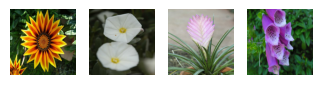

/tmp/ipykernel_169627/1965149211.py:10: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  noise = jax.random.normal(get_random_key(), shape=images.shape, dtype=jnp.float64)


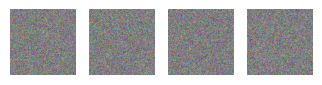

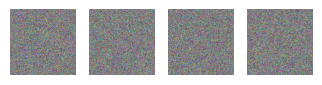

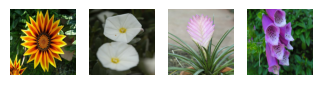

/tmp/ipykernel_169627/1965149211.py:18: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sample = jax.random.normal(get_random_key(), shape=images.shape, dtype=jnp.float64)


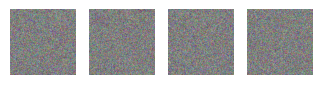

(Array([[[[0.00125451]]]], dtype=float32), Array([[[[0.9999992]]]], dtype=float32))


In [7]:
# Visualize adding some noise to some sample images and then removing it
reset_random_key()
data, _ = get_dataset("oxford_flowers102", batch_size=4, image_scale=256)
images = next(iter(data))
plotImages(images)
noise_level = 998# * jnp.ones((images.shape[0], ), dtype=jnp.int32)
noise_level_max = 1000
# schedule = DDPMLinearSchedule(timesteps=noise_level_max)
schedule = DDIMSchedule(timesteps=noise_level_max, min_signal_rate=0)
noise = jax.random.normal(get_random_key(), shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
plotImages(noisy_images)
plotImages(noise)
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)

# Now test sampling
sample = jax.random.normal(get_random_key(), shape=images.shape, dtype=jnp.float64)
for i in reversed(range(noise_level, noise_level_max)):
    step = jnp.ones(images.shape[0], dtype=jnp.int32) * i
    sample = schedule.sample_step(sample, noise, step)

plotImages(sample)
print(schedule.get_rates(noise_level))

# Modeling

## Metrics

## Callbacks

## Model Generator

In [8]:
# Built using the Flax NNX library

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nnx.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="normal")

class PixelShuffle(nnx.Module):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, x):
        up = einops.rearrange(
            x,
            pattern="b h w (h2 w2 c) -> b (h h2) (w w2) c",
            h2=self.scale_factor,
            w2=self.scale_factor,
        )
        return up
    
class TimeEmbedding(nnx.Module):
    def __init__(self, in_features, out_features, max_timesteps=10000):
        self.in_features = in_features
        self.out_features = out_features
        self.max_timesteps = max_timesteps
        # self.embeddings = nn.Embed(
        #     num_embeddings=max_timesteps, features=out_features
        # )
        half_dim = out_features // 2
        emb = jnp.log(max_timesteps) / (half_dim - 1)
        emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        self.embeddings = emb
    
    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x * self.embeddings
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb
    
class SinusoidalEmbedding(nnx.Module):
    def __init__(self, in_features, out_features, max_timesteps=10000):
        self.in_features = in_features
        self.out_features = out_features
        self.max_timesteps = max_timesteps
        # self.embeddings = nn.Embed(
        #     num_embeddings=max_timesteps, features=out_features
        # )
        half_dim = out_features // 2
        emb = jnp.exp(jnp.linspace(jnp.log(1),
                                    jnp.log(max_timesteps),
                                    half_dim))
        self.embeddings = emb
    
    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = self.embeddings * x
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb 
    
class TimeProjection(nnx.Module):
    def __init__(self, in_features, out_features, rngs: nnx.Rngs, activation=jax.nn.mish):
        self.kernel = nnx.Linear(in_features, out_features, kernel_init=kernel_init(1.0), rngs=rngs)
        self.norm = nnx.LayerNorm(out_features)
        self.act = activation

    def __call__(self, x):
        x = self.kernel(x)
        x = self.norm(x)
        x = self.act(x)
        return x
    
class SeparableConv(nnx.Module):
    def __init__(self, in_features, 
                 out_features, kernel_size, 
                 rngs:nnx.Rngs, 
                 strides=(1, 1),
                 use_bias=False, 
                 activation=jax.nn.mish,
                 kernel_init=kernel_init(1.0),
                 padding="SAME"
                 ):
        super(SeparableConv, self).__init__()
        self.depthwise = nnx.Conv(in_features, in_features, kernel_size=kernel_size, 
                                strides=strides, kernel_init=kernel_init, rngs=rngs,
                                feature_group_count=in_features, use_bias=use_bias, padding=padding)
        self.pointwise = nnx.Conv(in_features, out_features, 
                                strides=(1, 1), kernel_init=kernel_init, rngs=rngs,
                                kernel_size=(1 ,1), use_bias=use_bias)
    def __call__(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ConvLayer(nnx.Module):
    def __init__(self, conv_type, in_features, out_features, kernel_size=(3, 3), strides=(1, 1), rngs: nnx.Rngs=None, activation=jax.nn.mish):
        # conv_type can be "conv", "separable", "conv_transpose"
        if conv_type == "conv":
            self.conv = nnx.Conv(
                in_features=in_features,
                out_features=out_features,
                kernel_size=kernel_size,
                strides=strides,
                kernel_init=kernel_init(1.0),
                rngs=rngs,
            )
        elif conv_type == "separable":
            self.conv = SeparableConv(
                in_features=in_features,
                out_features=out_features,
                kernel_size=kernel_size,
                strides=strides,
                kernel_init=kernel_init(1.0),
                rngs=rngs,
            )
        elif conv_type == "conv_transpose":
            self.conv = nnx.ConvTranspose(
                in_features=in_features,
                out_features=out_features,
                kernel_size=kernel_size,
                strides=strides,
                kernel_init=kernel_init(1.0),
                rngs=rngs,
            )

    def __call__(self, x):
        return self.conv(x)
    
class Upsample(nnx.Module):
    def __init__(self, in_features, out_features, scale, rngs: nnx.Rngs, activation=jax.nn.mish):
        self.scale = scale
        self.conv = ConvLayer(
            "conv",
            in_features=in_features,
            out_features=out_features,
            kernel_size=(1, 1),
            strides=(1, 1),
            activation=activation,
            rngs=rngs
        )  
        self.pixel_shuffle = PixelShuffle(scale)

    def __call__(self, x, residual=None):
        out = self.pixel_shuffle(x)
        out = self.conv(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out
    
class Downsample(nnx.Module):
    def __init__(self, in_features, out_features, scale, rngs: nnx.Rngs, activation=jax.nn.mish):
        self.scale = scale
        self.conv = ConvLayer(
            "conv",
            in_features=in_features,
            out_features=out_features,
            kernel_size=(3, 3),
            strides=(2, 2),
            activation=activation,
            rngs=rngs
        )
    
    def __call__(self, x, residual=None):
        out = self.conv(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nnx.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class ResidualBlock(nnx.Module):
    def __init__(self,
                 conv_type, 
                 in_features, out_features, 
                 emb_features,
                 kernel_size=(3, 3), 
                 strides=(1, 1), padding='same', 
                 activation=jax.nn.mish,
                 direction=None,
                 res=2,
                 norm_groups=8,
                 attention_config={"heads":8},
                 rngs: nnx.Rngs=None
    ):
        self.branch1_conv1 = ConvLayer(
            conv_type, 
            in_features=in_features,
            out_features=out_features,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation,
            rngs=rngs
        )
        self.branch1_mlp = nnx.Linear(emb_features, out_features, kernel_init=kernel_init(1.0), rngs=rngs)
        self.branch1_norm1 = nnx.LayerNorm(out_features, rngs=rngs)
        self.branch1_act1 = activation
        self.branch1_conv2 = ConvLayer(
            conv_type, 
            in_features=out_features,
            out_features=out_features,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation,
            rngs=rngs
        )
        if in_features != out_features:
            self.branch2_conv1 = ConvLayer(
                conv_type, 
                in_features=in_features,
                out_features=out_features,
                kernel_size=1,
                strides=1,
                activation=activation,
                rngs=rngs
            )
        else:
            self.branch2_conv1 = lambda x: x
        if attention_config is not None:
            self.attention = nnx.MultiHeadAttention(
                num_heads=attention_config["heads"],
                in_features=out_features,
                out_features=out_features,
                kernel_init=kernel_init(1.0),
                rngs=rngs,
                decode=False
            )
        else:
            self.attention = lambda x: x
            
        if direction == "down":
            self.scale_change = Downsample(
                in_features=out_features,
                out_features=out_features,
                scale=res,
                rngs=rngs,
                activation=activation
            )
        elif direction == "up":
            self.scale_change = Upsample(
                in_features=out_features,
                out_features=out_features,
                scale=res,
                rngs=rngs,
                activation=activation
            )
        else:
            self.scale_change = lambda x, y: jnp.concatenate([x, y], axis=-1) if y is not None else x
    
    def __call__(self, x, temb, extra_features=None):
        out = self.branch1_conv1(x)
        print("branch1_conv1", out.shape)
        temb = self.branch1_mlp(temb)
        out = out + temb
        print("out+temb", out.shape, temb.shape)
        out = self.branch1_norm1(out)
        out = self.branch1_act1(out)
        out = self.branch1_conv2(out)

        residual = self.branch2_conv1(x)
        out = out + residual

        print("interm output", out.shape)
        out = self.attention(out)
        print("attention output", out.shape)
        
        out = self.scale_change(out, extra_features)
        print("final output", out.shape)
        return out
    
class Unet(nnx.Module):
    def __init__(self,
                    in_features=3,
                    out_features=3,
                    emb_features=64*4,
                    feature_depths=[64, 96, 128, 160, 192],
                    attention_config=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
                    num_res_blocks=1,
                    rngs: nnx.Rngs=None
    ):
        self.feature_depths = feature_depths
        self.num_res_blocks = num_res_blocks
        self.emb_features = emb_features
        self.in_features = in_features
        self.out_features = out_features
        self.attention_config = attention_config
        self.time_embedding = TimeEmbedding(1, emb_features)
        self.emb_projection = nnx.Linear(emb_features, emb_features, kernel_init=kernel_init(1.0), rngs=rngs)
        
        self.downs = []
        last_features = in_features
        for i, (features, attention) in enumerate(zip(feature_depths, attention_config)):
            for j in range(num_res_blocks):
                direction = "down" if j == num_res_blocks - 1 else None
                resblock = ResidualBlock(
                    "conv", 
                    in_features=last_features,
                    out_features=features,
                    emb_features=emb_features,
                    attention_config=attention,
                    direction=direction,
                    rngs=rngs,
                )
            self.downs.append(resblock)
            last_features = features + last_features
            
        self.middle = []
        for i in range(num_res_blocks):
            resblock = ResidualBlock(
                "conv", 
                in_features=last_features,
                out_features=last_features,
                emb_features=emb_features,
                attention_config=None,
                rngs=rngs,
            )
            self.middle.append(resblock)

        self.ups = []
        for i, (features, attention) in enumerate(zip(reversed(feature_depths), reversed(attention_config))):
            for j in range(num_res_blocks):
                direction = "up" if j == 0 else None
                resblock = ResidualBlock(
                    "conv", 
                    in_features=last_features,
                    out_features=features,
                    emb_features=emb_features,
                    attention_config=attention,
                    direction=direction,
                    rngs=rngs,
                )
            self.ups.append(resblock)
            last_features = features + last_features

        self.final_conv = nnx.Conv(
            in_features=last_features,
            out_features=out_features,
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0),
            rngs=rngs
        )

    def __call__(self, x, t):
        temb = self.time_embedding(t)
        print("time embedding", temb.shape)
        temb = self.emb_projection(temb)
        print("emb projection", temb.shape)
        extra_features = x
        for down in self.downs:
            print("adding down", x.shape)
            x = down(x, temb, extra_features)
            extra_features = x
        return x

In [9]:
sep = SeparableConv(3, 128, (3, 3), strides=(2, 2), rngs=nnx.Rngs(0))
x = jnp.ones((1, 256, 256, 3))
y = sep(x)
print(y.shape)

(1, 128, 128, 128)


In [10]:
temb = TimeEmbedding(1, 64)
x = jnp.ones((4, 1, 1, 1))

y = temb(x)
print(y.shape)

(4, 1, 1, 64)


In [11]:
inp = jnp.ones((4, 64, 64, 3), dtype=jnp.float32)
temb = jnp.ones((4, 1, 1, 1), dtype=jnp.float32)

unet = Unet(in_features=3, out_features=3, emb_features=256, 
            feature_depths=[64, 96, 128, 160, 192], 
            attention_config=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}], 
            num_res_blocks=1, rngs=nnx.Rngs(0))


time embedding (4, 1, 1, 256)
emb projection (4, 1, 1, 256)
adding down (4, 64, 64, 3)
branch1_conv1 (4, 64, 64, 64)
out+temb (4, 64, 64, 64) (4, 1, 1, 64)
interm output (4, 64, 64, 64)
attention output (4, 64, 64, 64)
final output (4, 32, 32, 67)
adding down (4, 32, 32, 67)
branch1_conv1 (4, 32, 32, 96)
out+temb (4, 32, 32, 96) (4, 1, 1, 96)
interm output (4, 32, 32, 96)
attention output (4, 32, 32, 96)
final output (4, 16, 16, 163)
adding down (4, 16, 16, 163)
branch1_conv1 (4, 16, 16, 128)
out+temb (4, 16, 16, 128) (4, 1, 1, 128)
interm output (4, 16, 16, 128)
attention output (4, 16, 16, 128)
final output (4, 8, 8, 291)
adding down (4, 8, 8, 291)
branch1_conv1 (4, 8, 8, 160)
out+temb (4, 8, 8, 160) (4, 1, 1, 160)
interm output (4, 8, 8, 160)
attention output (4, 8, 8, 160)
final output (4, 4, 4, 451)
adding down (4, 4, 4, 451)
branch1_conv1 (4, 4, 4, 192)
out+temb (4, 4, 4, 192) (4, 1, 1, 192)
interm output (4, 4, 4, 192)
attention output (4, 4, 4, 192)
final output (4, 2, 2, 643)


In [12]:
y = unet(inp, temb)

time embedding (4, 1, 1, 256)
emb projection (4, 1, 1, 256)
adding down (4, 64, 64, 3)
branch1_conv1 (4, 64, 64, 64)
out+temb (4, 64, 64, 64) (4, 1, 1, 64)
interm output (4, 64, 64, 64)
attention output (4, 64, 64, 64)
final output (4, 32, 32, 67)
adding down (4, 32, 32, 67)
branch1_conv1 (4, 32, 32, 96)
out+temb (4, 32, 32, 96) (4, 1, 1, 96)
interm output (4, 32, 32, 96)
attention output (4, 32, 32, 96)
final output (4, 16, 16, 163)
adding down (4, 16, 16, 163)
branch1_conv1 (4, 16, 16, 128)
out+temb (4, 16, 16, 128) (4, 1, 1, 128)
interm output (4, 16, 16, 128)
attention output (4, 16, 16, 128)
final output (4, 8, 8, 291)
adding down (4, 8, 8, 291)
branch1_conv1 (4, 8, 8, 160)
out+temb (4, 8, 8, 160) (4, 1, 1, 160)
interm output (4, 8, 8, 160)
attention output (4, 8, 8, 160)
final output (4, 4, 4, 451)
adding down (4, 4, 4, 451)
branch1_conv1 (4, 4, 4, 192)
out+temb (4, 4, 4, 192) (4, 1, 1, 192)
interm output (4, 4, 4, 192)
attention output (4, 4, 4, 192)
final output (4, 2, 2, 643)


In [25]:
graphdef, params, rest = nnx.split(unet, nnx.Param, ...)

# print(params.__dict__)
parameter_overview.get_parameter_overview(params.flat_state())

ValueError: Expected tuple, got VariableState(
  type=Param,
  value=array([[[[-0.10610101,  0.14379254,  0.13636215, ..., -0.02472201,
            -0.20795965, -0.10828701],
           [-0.05235888,  0.04665525,  0.20502646, ..., -0.00105093,
            -0.01709283, -0.00358695],
           [-0.04593134, -0.14315577, -0.3586952 , ...,  0.09578057,
             0.16084868, -0.20325604],
           ...,
           [-0.06938041, -0.23163576,  0.01525324, ..., -0.17104474,
             0.03050876,  0.05056323],
           [-0.1383329 ,  0.00441571,  0.08128905, ..., -0.03737465,
             0.08381297,  0.08069821],
           [ 0.00042145,  0.03771184,  0.06105393, ..., -0.02479343,
             0.06087295,  0.10752892]]]], dtype=float32)
).

In [14]:
nnx.display(unet)

In [20]:
nnx.display(params)

In [45]:
sum([jnp.size(i) for i in jax.tree_util.tree_leaves(params)])

18678661

# Training